In [1]:
import numpy as np
import FuncParcel
from scipy import stats
import matplotlib.pyplot as plt
import nibabel as nib
import matplotlib as mpl
from matplotlib import colors
import pickle
from collections import Counter
%matplotlib inline
from sklearn.metrics import normalized_mutual_info_score as NMI
from sklearn.metrics import adjusted_rand_score as RAND

# load subcortical voxel info
Thalamus_voxel_coordinate = np.loadtxt('/home/despoB/connectome-thalamus/ROIs/thalamus_voxels_ijk_indices', dtype = int)

subcorticalcortical_ROIs = np.loadtxt('/home/despoB/connectome-thalamus/ROIs/Gordon_CI_plus_thalamus_ROIs')
subcortical_voxels = np.loadtxt('/home/despoB/connectome-thalamus/ROIs/thalamus_voxel_indices')
cortical_ROIs =np.loadtxt('/home/despoB/connectome-thalamus/ROIs/Gordon_Network_consensusCI')
Cortical_CI = np.loadtxt('/home/despoB/connectome-thalamus/ROIs/Gordon_Network_consensusCI')

#create a mask based on the morel atlas 
Morel_atlas = np.loadtxt('/home/despoB/connectome-thalamus/Thalamic_parcel/Morel_parcel')
Morel_mask = np.loadtxt('/home/despoB/connectome-thalamus/Thalamic_parcel/morel_mask')
mask_value = Morel_mask==0

# Functional Atlas, WTA Parcellation

In [2]:
#path to files ncessary for parcellation
MGHadjmat = np.loadtxt('/home/despoB/connectome-thalamus/Thalamic_parcel/MGH_Gordon_ConsesnsusCI_thalamocortical_pcorr_avemat')
NKIadjmat = np.loadtxt('/home/despoB/connectome-thalamus/Thalamic_parcel/NKI_645_Gordon_ConsesnsusCI_thalamocortical_pcorr_avemat')

#call function
_, MGH_ParcelCIs, _, = FuncParcel.parcel_subcortical_network(MGHadjmat, subcorticalcortical_ROIs, \
            subcortical_voxels, cortical_ROIs, Cortical_CI)
_, NKI_ParcelCIs, _, = FuncParcel.parcel_subcortical_network(NKIadjmat, subcorticalcortical_ROIs, \
            subcortical_voxels, cortical_ROIs, Cortical_CI)

## Display thalamic parcellation over MNI template

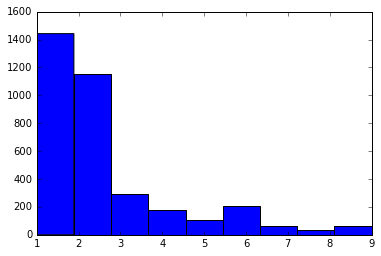

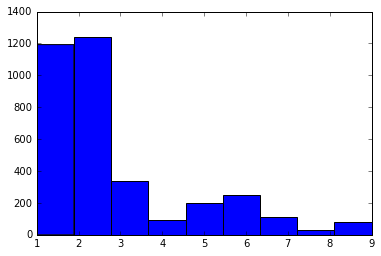

NMI = 0.691387734025
RAND = 0.804138076264


In [3]:
# sort CI vector
def sort_CI(Thalamo_ParcelCIs):
    CIs = np.zeros(len(Thalamus_voxel_coordinate))
    for i, thalamus_voxel_index in enumerate(Thalamus_voxel_coordinate[:,3]):
        CIs[i] = Thalamo_ParcelCIs[thalamus_voxel_index][0]
    CIs = CIs.astype(int)
    return CIs
                        

NKI_CIs = sort_CI(NKI_ParcelCIs)
MGH_CIs = sort_CI(MGH_ParcelCIs)

plt.hist(NKI_CIs, bins=np.max(np.unique(NKI_CIs)))
plt.show()
plt.hist(MGH_CIs, bins=np.max(np.unique(MGH_CIs)))
plt.show()
NKI_CIs[mask_value]=0
MGH_CIs[mask_value]=0

print 'NMI =', NMI(NKI_CIs, MGH_CIs)
print 'RAND =', RAND(NKI_CIs, MGH_CIs)

np.savetxt('/home/despoB/connectome-thalamus/Thalamic_parcel/MGH_Thalamus_WTA_CIs', MGH_CIs, )
np.savetxt('/home/despoB/connectome-thalamus/Thalamic_parcel/NKI_Thalamus_WTA_CIs', NKI_CIs, )
#FuncParcel.save_object(MGH_CIs, '/home/despoB/kaihwang/bin/FuncParcel/Data/MGH_Thalamus_CIs')

In [106]:
def visualize_parcellation(CIs, cmap, savepath):
    # show volum image
    MNI_img = nib.load('/home/despoB/connectome-thalamus/ROIs/MNI152_T1_2mm_brain.nii.gz')
    MNI_data = MNI_img.get_data()

    # create mask for parcel
    Mask = np.zeros(MNI_data.shape)


    # assign CI to each subcortical voxel
    for i, CI in enumerate(CIs):
        Mask[Thalamus_voxel_coordinate[i,0], Thalamus_voxel_coordinate[i,1], Thalamus_voxel_coordinate[i,2]] = CIs[i].astype(int)
    Mask = np.ma.masked_where(Mask == 0, Mask)

    # flip dimension to show anteiror of the brain at top
    MNI_data = MNI_data.swapaxes(0,1)
    Mask = Mask.swapaxes(0,1)

    # some plot setting (colormap), interplotation..
    #cmap = colors.ListedColormap(['red', 'blue', 'cyan', 'yellow', 'teal', 'purple', 'pink', 'green', 'black'])
    #cmap = colors.ListedColormap(['blue', 'red', 'cyan', 'yellow', 'green'])
    # display slice by slice
    Z_slices = range(np.min(Thalamus_voxel_coordinate[:,2])+2, np.max(Thalamus_voxel_coordinate[:,2])-1,2)
    fig = plt.figure()
    for i, Z_slice in enumerate(Z_slices):
        #if i <4:
        a = plt.subplot(1, len(Z_slices), i+1 )
        #else:
        #    a = plt.subplot(2, len(Z_slices)/2, i+1-4 )
        a.set_yticks([])
        a.set_xticks([])
        plt.imshow(MNI_data[45:65, 30:60, Z_slice], cmap='gray', interpolation='nearest')
        plt.imshow(Mask[45:65, 30:60, Z_slice],cmap=cmap, interpolation='none', vmin = 1, vmax=np.max(CIs))
        plt.ylim(plt.ylim()[::-1])
        
    fig.tight_layout() 
    fig.set_size_inches(6.45, 0.7) 
    
    plt.savefig(savepath, bbox_inches='tight')

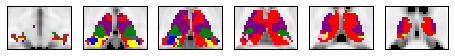

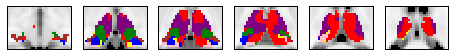

In [128]:
cmap = colors.ListedColormap(['red', 'purple', 'green', 'yellow', 'cyan', 'blue', 'brown', 'pink', 'teal', 'pink'])
NKI_CIs[mask_value]=0
MGH_CIs[mask_value]=0
visualize_parcellation(NKI_CIs, cmap, 'Data/NKI_CI_WTA_Tha_Parcel.png')
visualize_parcellation(MGH_CIs, cmap, 'Data/MGH_CI_WTA_Tha_Parcel.png')

# Visualize Morel anatomcial Parcellation

In [127]:
Morel_atlas = np.loadtxt('/home/despoB/connectome-thalamus/Thalamic_parcel/Morel_parcel')

## consolidate some of the smaller nuclei into larger nuclear groups
#AN
Morel_atlas[Morel_atlas == 2] =1
Morel_atlas[Morel_atlas == 3] =1
Morel_atlas[Morel_atlas == 4] =1

#MD
Morel_atlas[Morel_atlas == 6] =5

#IL
Morel_atlas[Morel_atlas == 9] =8
Morel_atlas[Morel_atlas == 10] =8
Morel_atlas[Morel_atlas == 11] =8
Morel_atlas[Morel_atlas == 19] =8
Morel_atlas[Morel_atlas == 18] =0 #these are voxls that can't be classified

#LGN
Morel_atlas[Morel_atlas == 21] =11
Morel_atlas[Morel_atlas == 22] =11

#MGN
Morel_atlas[Morel_atlas == 17] =4

#VP
Morel_atlas[Morel_atlas == 23] =17
Morel_atlas[Morel_atlas == 24] =17
Morel_atlas[Morel_atlas == 25] =17
Morel_atlas[Morel_atlas == 26] =17

#PO
Morel_atlas[Morel_atlas == 20] =10

#VL
Morel_atlas[Morel_atlas == 27] =3
Morel_atlas[Morel_atlas == 28] =3
Morel_atlas[Morel_atlas == 29] =3

#VA
Morel_atlas[Morel_atlas == 31] =30
Morel_atlas[Morel_atlas == 30] =9

#VM 
Morel_atlas[Morel_atlas == 32] =2

#LP
Morel_atlas[Morel_atlas == 16] = 7

#
Morel_atlas[Morel_atlas == 15] = 6
Morel_atlas_coor = Thalamus_voxel_coordinate.copy()
Morel_atlas_coor [:,3]= Morel_atlas
Morel_atlas_coor[Morel_atlas_coor [:,3]==400,3]=0
np.savetxt('/home/despoB/connectome-thalamus/ROIs/Morel_consolidated', Morel_atlas_coor)

#here is the coding for the consolidated Morel parcels
#1 AN
#2 VM
#3 VL
#4 MGN
#5 MD
#6 PuA
#7 LP
#8 IL
#9 VA 
#10 Po
#11 PLGN
#12 PuM
#13 PuI
#14 PuL
#17 VP
np.unique(Morel_atlas)

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  17.])

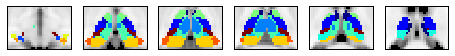

In [124]:
cmap = 'jet'
visualize_parcellation(Morel_atlas, cmap, 'Data/Morel_Parcel.png')

# Parcellation with the FSL atlas


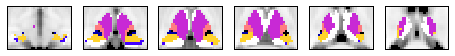

In [129]:
cmap = 'gnuplot2'
FSL_ana = np.loadtxt('/home/despoB/connectome-thalamus/Thalamic_parcel/fsl_thalamus_ana_parcel')
FSL_ana[mask_value]=0
#print np.unique(FSL_ana)
FSL_atlas_coor = Thalamus_voxel_coordinate.copy()
FSL_atlas_coor [:,3]= FSL_ana+400
np.savetxt('/home/despoB/connectome-thalamus/ROIs/FSLana_coor', FSL_atlas_coor)

visualize_parcellation(FSL_ana, cmap, 'Data/FSL_ana_Parcel.png')

# Visualize nodal properties (PC, WMDs... etc)

In [42]:
def visualize_nodal_property(CIs, lb, ub, savepath, colors):
    # show volum image
    MNI_img = nib.load('/home/despoB/connectome-thalamus/ROIs/MNI152_T1_2mm_brain.nii.gz')
    MNI_data = MNI_img.get_data()

    # create mask for parcel
    Mask = np.zeros(MNI_data.shape)


    # assign CI to each subcortical voxel
    for i, CI in enumerate(CIs):
        Mask[Thalamus_voxel_coordinate[i,0], Thalamus_voxel_coordinate[i,1], Thalamus_voxel_coordinate[i,2]] = CIs[i]
    Mask = np.ma.masked_where(Mask == 0, Mask)

    # flip dimension to show anteiror of the brain at top
    MNI_data = MNI_data.swapaxes(0,1)
    Mask = Mask.swapaxes(0,1)

    # some plot setting (colormap), interplotation..
    #cmap = colors.ListedColormap(['red', 'blue', 'cyan', 'yellow', 'teal', 'purple', 'pink', 'green', 'black'])
    #cmap = colors.ListedColormap(['blue', 'red', 'cyan', 'yellow', 'green'])
    cmap = plt.get_cmap(colors)
    # display slice by slice
    Z_slices = range(np.min(Thalamus_voxel_coordinate[:,2])+2, np.max(Thalamus_voxel_coordinate[:,2])-1,2)
    fig = plt.figure()
    for i, Z_slice in enumerate(Z_slices):
        a = plt.subplot(2, len(Z_slices)/2, i+1 )
        a.set_yticks([])
        a.set_xticks([])
        plt.imshow(MNI_data[45:65, 30:60, Z_slice], cmap='gray', interpolation='nearest')
        im=plt.imshow(Mask[45:65, 30:60, Z_slice],cmap=cmap, interpolation='none', vmin =lb, vmax=ub)
        plt.ylim(plt.ylim()[::-1])

    cbar_ax = fig.add_axes([1.02,.25,.025,.52])
    cbar = fig.colorbar(im, cax=cbar_ax, ticks=[lb, ub])
    cbar.ax.tick_params(labelsize=12)
    fig.tight_layout() 
    fig.set_size_inches(4.5,2.5)
    plt.savefig(savepath, bbox_inches='tight')

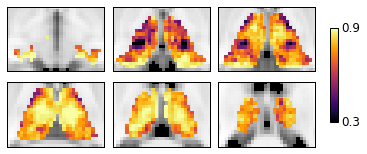

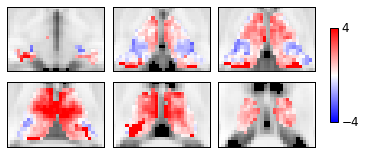

In [135]:
AvePC = pickle.load(open("/home/despoB/connectome-thalamus/Graph/MGH_avemat_tha_nodal_pcorr_meanPC"))
PCs = AvePC[333:]/100 #data scaled for easier NIFTI manipulation...
PCs[mask_value]=0 
visualize_nodal_property(PCs, 0.3, 0.9,'Data/MGH_Gordon_PC.png','inferno')
AveWMD = pickle.load(open("/home/despoB/connectome-thalamus/Graph/MGH_avemat_tha_nodal_pcorr_meanWMD"))
WMD = AveWMD[333:]/100
WMD[mask_value]=np.nan
visualize_nodal_property(WMD, -4,4,'Data/MGH_Gordon_WMD.png','bwr')

In [131]:
def visualize_parcellation(CIs, cmap, savepath):
    # show volum image
    MNI_img = nib.load('/home/despoB/connectome-thalamus/ROIs/MNI152_T1_2mm_brain.nii.gz')
    MNI_data = MNI_img.get_data()

    # create mask for parcel
    Mask = np.zeros(MNI_data.shape)


    # assign CI to each subcortical voxel
    for i, CI in enumerate(CIs):
        Mask[Thalamus_voxel_coordinate[i,0], Thalamus_voxel_coordinate[i,1], Thalamus_voxel_coordinate[i,2]] = CIs[i].astype(int)
    Mask = np.ma.masked_where(Mask == 0, Mask)

    # flip dimension to show anteiror of the brain at top
    MNI_data = MNI_data.swapaxes(0,1)
    Mask = Mask.swapaxes(0,1)

    # some plot setting (colormap), interplotation..
    #cmap = colors.ListedColormap(['red', 'blue', 'cyan', 'yellow', 'teal', 'purple', 'pink', 'green', 'black'])
    #cmap = colors.ListedColormap(['blue', 'red', 'cyan', 'yellow', 'green'])
    # display slice by slice
    Z_slices = range(np.min(Thalamus_voxel_coordinate[:,2])+2, np.max(Thalamus_voxel_coordinate[:,2])-1,2)
    fig = plt.figure()
    for i, Z_slice in enumerate(Z_slices):
        #if i <4:
        a = plt.subplot(2, len(Z_slices)/2, i+1 )
        #else:
        #    a = plt.subplot(2, len(Z_slices)/2, i+1-4 )
        a.set_yticks([])
        a.set_xticks([])
        plt.imshow(MNI_data[45:65, 30:60, Z_slice], cmap='gray', interpolation='nearest')
        plt.imshow(Mask[45:65, 30:60, Z_slice],cmap=cmap, interpolation='none', vmin = 1, vmax=len(np.unique(CIs)))
        plt.ylim(plt.ylim()[::-1])
        
    fig.tight_layout() 
    fig.set_size_inches(4.5, 2.5) 
    
    plt.savefig(savepath, bbox_inches='tight')

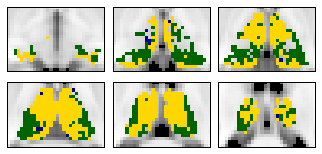

In [134]:
## get connector or pro voxels

TopPC = (PCs>0.64)*2
TopWMD = (WMD>1.04)*1
ALL = TopPC +TopWMD
cmap = colors.ListedColormap(['darkblue', 'darkgreen', 'gold'])
visualize_parcellation(ALL, cmap, 'Data/MGH_Gordon_Tha_NodeType.png')

# Replication

In [12]:
MGHPC = pickle.load(open("/home/despoB/connectome-thalamus/Graph/MGH_avemat_tha_nodal_pcorr_PCs"))
NKIPC = pickle.load(open("/home/despoB/connectome-thalamus/Graph/NKI_1400_avemat_tha_nodal_pcorr_PCs"))

print np.corrcoef(MGHPC, NKIPC)

MGHWMD = pickle.load(open("/home/despoB/connectome-thalamus/Graph/MGH_avemat_tha_nodal_pcorr_WMDs"))
NKIWMD = pickle.load(open("/home/despoB/connectome-thalamus/Graph/NKI_1400_avemat_tha_nodal_pcorr_WMDs"))

print np.corrcoef(MGHWMD, NKIWMD)

MGH_Craddock_PC = pickle.load(open("/home/despoB/kaihwang/bin/FuncParcel/Data/MGH_Tha_PCs"))
MGH_Craddock_WMD = pickle.load(open("/home/despoB/kaihwang/bin/FuncParcel/Data/MGH_Tha_WMDs"))

NKI_Craddock_PC = pickle.load(open("/home/despoB/kaihwang/bin/FuncParcel/Data/NKI_Tha_PCs"))
NKI_Craddock_WMD = pickle.load(open("/home/despoB/kaihwang/bin/FuncParcel/Data/NKI_Tha_WMDs"))

print np.corrcoef(MGHPC[333:], MGH_Craddock_PC[320:])
print np.corrcoef(NKI_Craddock_PC, MGH_Craddock_PC)

[[ 1.          0.73547658]
 [ 0.73547658  1.        ]]
[[ 1.          0.77920131]
 [ 0.77920131  1.        ]]
[[ 1.          0.62922403]
 [ 0.62922403  1.        ]]
[[ 1.          0.78044282]
 [ 0.78044282  1.        ]]


# Visualize lesion maps

In [51]:
def visualize_lesions(fn, lesion_mask, savepath):
    # show volum image
    MNI_img = nib.load(fn)
    MNI_data = MNI_img.get_data()
    
    lesion_img = nib.load(lesion_mask)
    lesion_data = lesion_img.get_data()
    lesion_data = np.ma.masked_where(lesion_data == 0, lesion_data)
    # create mask for parcel
    #Mask = np.zeros(MNI_data.shape)

    # flip dimension to show anteiror of the brain at top
    MNI_data = MNI_data.swapaxes(0,1)
    lesion_data = lesion_data.swapaxes(0,1)
    
    Z_slices = range(np.min(Thalamus_voxel_coordinate[:,2])+2, np.max(Thalamus_voxel_coordinate[:,2])-1,2)
    fig = plt.figure()
    for i, Z_slice in enumerate(Z_slices):
        #if i <4:
        a = plt.subplot(2, len(Z_slices)/2, i+1 )
        #else:
        #    a = plt.subplot(2, len(Z_slices)/2, i+1-4 )
        a.set_yticks([])
        a.set_xticks([])
        plt.imshow(MNI_data[40:70, 30:63, Z_slice], cmap='gray', interpolation='nearest')
        plt.imshow(lesion_data[40:70, 30:63, Z_slice],cmap='Set1',interpolation='none' ) 
        plt.ylim(plt.ylim()[::-1])
        
    fig.tight_layout() 
    fig.set_size_inches(3.5, 2) 
    
    plt.savefig(savepath, bbox_inches='tight')

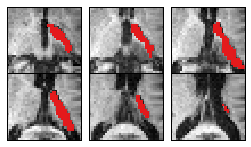

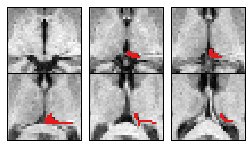

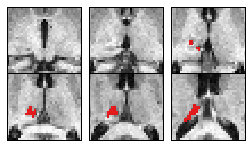

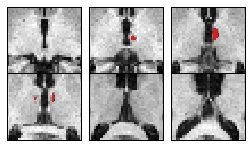

In [53]:
visualize_lesions('/home/despoB/kaihwang/Rest/Lesion_Masks/163_MNI_final_2x2x2.nii.gz','/home/despoB/kaihwang/Rest/Lesion_Masks/163_lesion_mask_MNI_2x2x2.nii.gz', 'Data/S1.png')
visualize_lesions('/home/despoB/kaihwang/Rest/Lesion_Masks/128_MNI_final_2x2x2.nii.gz','/home/despoB/kaihwang/Rest/Lesion_Masks/128_lesion_mask_MNI_2x2x2.nii.gz', 'Data/S2.png')
visualize_lesions('/home/despoB/kaihwang/Rest/Lesion_Masks/168_MNI_final_2x2x2.nii.gz','/home/despoB/kaihwang/Rest/Lesion_Masks/168_lesion_mask_MNI_2x2x2.nii.gz', 'Data/S3.png')
visualize_lesions('/home/despoB/kaihwang/Rest/Lesion_Masks/176_MNI_final_2x2x2.nii.gz','/home/despoB/kaihwang/Rest/Lesion_Masks/176_lesion_mask_MNI_2x2x2.nii.gz', 'Data/S4.png')
